In [3]:
import collections
import numpy as np
import pandas as pd
import re
import glob
import json

%matplotlib inline
import matplotlib.pyplot as plt

from argparse import Namespace

from torchtext.utils import download_from_url, extract_archive

from wordcloud import WordCloud

from collections import Counter

Download the data from the [here](https://drive.google.com/uc?id=1k7GfVRqrHFK00ABkit0oGQo62fCakMSZ).   

Extract it to the folder called `.data`

In [4]:
args = Namespace(
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_processed_csv_prefix=".data/faq_with_splits_",
    seed=1234,
    min_questions_per_category=3000
)

In [5]:
def find_files(path):
    return glob.glob(path)

def read_json(filename):
    with open(filename, encoding='utf-8', errors='ignore') as json_file:
        data = json.load(json_file)
    return data

In [6]:
frames = []

for file in find_files('.data/gyakori_*'):
    print("Reading file:", file)
    frames.append(pd.DataFrame(read_json(file)))
    
faq = pd.concat(frames).reset_index(drop=True)

Reading file: .data\gyakori_allatok_14000
Reading file: .data\gyakori_egeszseg
Reading file: .data\gyakori_egeszseg_20000
Reading file: .data\gyakori_szamitastechnika
Reading file: .data\gyakori_szorakozas_30000


In [7]:
faq.head()

,rovid_kerdes,hosszu_kerdes,valasz,kategoriak,keywords
0,Nagy terület őrzésére milyen kutyát javasolnát...,Nagy terület őrzésére milyen kutyát javasolnát...,A komondor/kuvasz páros kimondottan ezekre a f...,"[Állatok, Kutyák]","[kutya, őrkutya, aktív]"
1,Az álllatorvosunkat alig lehet elérni. Ez szer...,Az álllatorvosunkat alig lehet elérni. Ez szer...,Keress másik orvost. Ennyi.,"[Állatok, Egyéb kérdések]","[állatorvos, időpont]"
2,Huskyval össze lehet szoktatni cicákat?,Huskyval össze lehet szoktatni cicákat? A cica...,"Persze, hogy össze lehet.A kutyának az első pi...","[Állatok, Kutyák]","[husky, kutya, cica, összeszoktatás]"
3,Jár a kutyám feje jobbra balra és a szeme is m...,Jár a kutyám feje jobbra balra és a szeme is m...,Akkor a fenti youtube video es az alatta levo ...,"[Állatok, Kutyák]","[kutya, betegség, szem, állat, orvos]"
4,Vadászok! Vennék egy vizslát hobbi célra de el...,Vadászok! Vennék egy vizslát hobbi célra de el...,Normál esetben egy jó idegrendszerű kutyát nem...,"[Állatok, Kutyák]","[vadászat, vizsla, kutya, állat, vad, lövés, p..."


In [8]:
faq.rename(columns = {
        "valasz": "answer",
        "kategoriak": "categories",
        "hosszu_kerdes": "long_question",
        "rovid_kerdes": "short_question"
    }, inplace = True)

In [9]:
faq['main_category'] = faq.apply(lambda row: row.categories[0], axis = 1)
faq['sub_category'] = faq.apply(lambda row: row.categories[1], axis = 1)

In [36]:
counter = Counter()
cs_faq = faq[faq.main_category == "Számítástechnika"]
_ = cs_faq.keywords.apply(lambda words: counter.update(words))

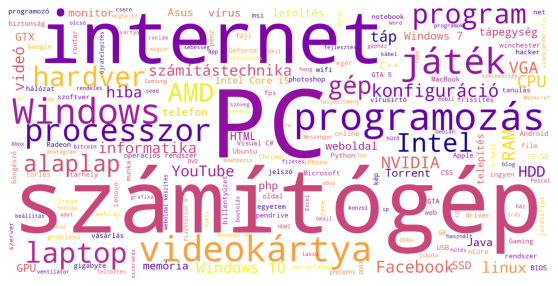

In [39]:
wordcloud = WordCloud(background_color="white", scale=5, colormap="plasma")
wordcloud.generate_from_frequencies(frequencies=counter)
plt.figure(figsize=(16, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [8]:
faq = faq.drop('keywords', axis = 1)
faq = faq.drop('categories', axis = 1)

In [9]:
faq.head()

,short_question,long_question,answer,main_category,sub_category
0,Nagy terület őrzésére milyen kutyát javasolnát...,Nagy terület őrzésére milyen kutyát javasolnát...,A komondor/kuvasz páros kimondottan ezekre a f...,Állatok,Kutyák
1,Az álllatorvosunkat alig lehet elérni. Ez szer...,Az álllatorvosunkat alig lehet elérni. Ez szer...,Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések
2,Huskyval össze lehet szoktatni cicákat?,Huskyval össze lehet szoktatni cicákat? A cica...,"Persze, hogy össze lehet.A kutyának az első pi...",Állatok,Kutyák
3,Jár a kutyám feje jobbra balra és a szeme is m...,Jár a kutyám feje jobbra balra és a szeme is m...,Akkor a fenti youtube video es az alatta levo ...,Állatok,Kutyák
4,Vadászok! Vennék egy vizslát hobbi célra de el...,Vadászok! Vennék egy vizslát hobbi célra de el...,Normál esetben egy jó idegrendszerű kutyát nem...,Állatok,Kutyák


In [10]:
faq[faq.short_question.str.contains('\r')]

,short_question,long_question,answer,main_category,sub_category
153117,Tényleg ez történik a Star Wars-ban?\r\n\r\nSP...,Tényleg ez történik a Star Wars-ban?\r \r SPOI...,"Azert most mar jo ideje kint van a film, unnep...",Szórakozás,"Filmek, sorozatok"


In [11]:
def clear_escaped_characters(text):
    text = text.replace('\n', ' ')
    return text.replace('\r', ' ')

In [12]:
faq.long_question = faq.long_question.apply(lambda x: clear_escaped_characters(x))
faq.short_question = faq.short_question.apply(lambda x: clear_escaped_characters(x))
faq.answer = faq.answer.apply(lambda x: clear_escaped_characters(x))

In [13]:
faq = faq[~faq.long_question.str.contains('\[link\]') & ~faq.answer.str.contains('\[link\]')]

In [14]:
categories = set(faq.main_category)
print(categories)

{'Egészség', 'Számítástechnika', 'Szórakozás', 'Állatok', 'Gyerekvállalás, nevelés'}


In [32]:
def number_of_questions_by_category():
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle('Number of questions per categories')

    grouped_faq = faq.groupby(faq.main_category)
    data_to_plot = grouped_faq.size().sort_values()

    data_to_plot.plot(kind='pie', ax=ax[0], autopct='%1.1f%%')
    data_to_plot.plot(kind='bar', ax=ax[1])

    y_axis_0 = ax[0].axes.get_yaxis()
    y_axis_0.set_visible(False)

    ax[1].set_xlabel("")
    ax[1].bar_label(ax[1].containers[0])
    
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(0)

    plt.show()

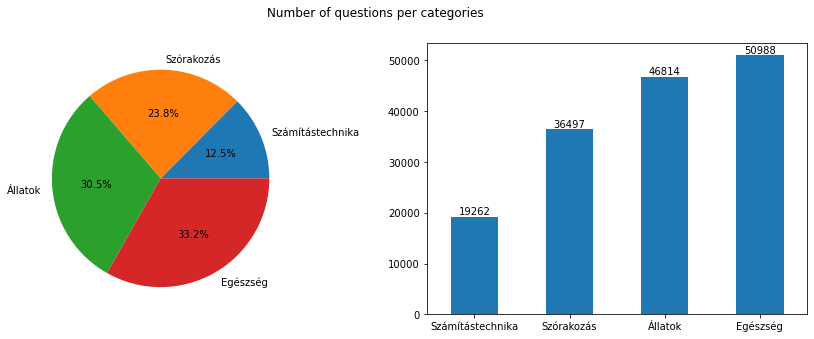

In [33]:
number_of_questions_by_category()

In [34]:
for category in categories:
    category_size = faq[faq.main_category == category].shape[0]
    if category_size < args.min_questions_per_category:
        faq = faq[faq.main_category != category]

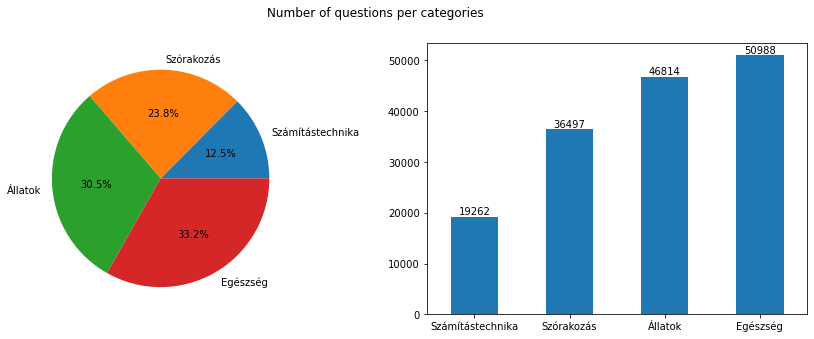

In [35]:
number_of_questions_by_category()

In [19]:
faq = faq.reset_index(drop=True)

In [20]:
def add_splits(df):
    categories = set(df.main_category)

    for category in categories:
        df_ctg = df[df.main_category == category]
        df_ctg = df_ctg.sample(frac=1)
        
        n = df_ctg.shape[0]
        n_train = int(args.train_proportion * n)
        n_val = int(args.val_proportion * n)
        n_test = int(args.test_proportion * n)

        df.loc[df_ctg[:n_train].index.values, 'split'] = 'train'
        df.loc[df_ctg[n_train:n_train+n_val].index.values, 'split'] = 'val'
        df.loc[df_ctg[n_train+n_val:].index.values, 'split'] = 'test'
                
    return df

In [21]:
faq_with_splits = add_splits(faq)

In [22]:
faq_with_splits.head()

,short_question,long_question,answer,main_category,sub_category,split
0,Nagy terület őrzésére milyen kutyát javasolnát...,Nagy terület őrzésére milyen kutyát javasolnát...,A komondor/kuvasz páros kimondottan ezekre a f...,Állatok,Kutyák,train
1,Az álllatorvosunkat alig lehet elérni. Ez szer...,Az álllatorvosunkat alig lehet elérni. Ez szer...,Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések,val
2,Huskyval össze lehet szoktatni cicákat?,Huskyval össze lehet szoktatni cicákat? A cica...,"Persze, hogy össze lehet.A kutyának az első pi...",Állatok,Kutyák,train
3,Vadászok! Vennék egy vizslát hobbi célra de el...,Vadászok! Vennék egy vizslát hobbi célra de el...,Normál esetben egy jó idegrendszerű kutyát nem...,Állatok,Kutyák,train
4,Elszállásolhatok kutyát panellakásban néhány n...,Elszállásolhatok kutyát panellakásban néhány n...,"Az a házirend rész érvénytelen, amiben ilyent ...",Állatok,Egyéb kérdések,train


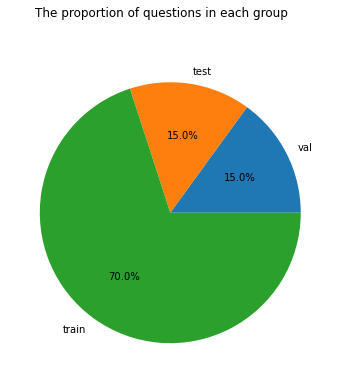

In [31]:
fig, ax = plt.subplots(1, figsize=(10, 6))

fig.suptitle('The proportion of questions in each group')
data_to_plot = faq_with_splits.groupby(faq_with_splits.split).size().sort_values()

data_to_plot.plot(kind='pie', ax=ax, autopct='%1.1f%%')

y_axis_0 = ax.axes.get_yaxis()
y_axis_0.set_visible(False)

plt.show()

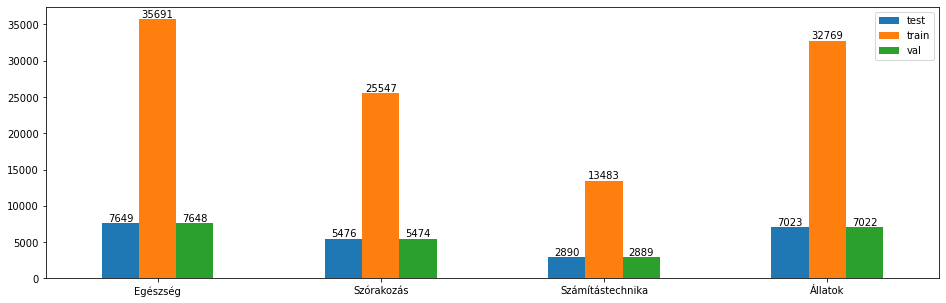

In [24]:
fig, ax = plt.subplots(1, figsize=(16, 5))

splits = list(set(faq_with_splits.split))

index = set(faq_with_splits.main_category)
questions_in = {}

for split in splits:
    questions_in[split] = []
    faq_split = faq_with_splits[faq_with_splits.split == split]
    
    for category in index:
        questions_in[split].append(faq_split[faq_split.main_category == category].shape[0])

df = pd.DataFrame({split: questions_in[split] for split in splits}, index=index)        
df.head()

df.plot(kind='bar',ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

for label in ax.containers:
    ax.bar_label(label)

plt.show()

### Lemmatization, stemming, stop-word filtering

Install [Hungarian spaCy modell](https://github.com/huspacy/huspacy)
```
pip install https://github.com/huspacy/huspacy/releases/download/hu_core_ud_lg-0.3.1/hu_core_ud_lg-0.3.1-py3-none-any.whl
```

In [28]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import HungarianStemmer
from nltk.corpus import stopwords

import nltk

import hu_core_ud_lg

In [29]:
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('hungarian'))

In [30]:
tokenizer = RegexpTokenizer(r'\w+')

stemmer = HungarianStemmer()

question = faq_with_splits.iloc[2]['long_question']

# Tokenization
tokenized_sentence = tokenizer.tokenize(question)

# Stopword filtering
filtered_sentence = [w for w in tokenized_sentence if not w in stop_words]

# Lemmatization
lemmatizer = hu_core_ud_lg.load()

lemmatizer.remove_pipe('parser')
lemmatizer.remove_pipe('ner')
lemmatizer.add_pipe(lemmatizer.create_pipe('sentencizer'))

doc = lemmatizer(" ".join(filtered_sentence))

In [36]:
print(f"Original question:\n{question}\n")

print("After tokenization:")
for w in tokenized_sentence:
    print(w, end=" ")

print("\n\nAfter stopword filtering:")
for w in filtered_sentence:
    print(w, end=" ")

print("\n\nAfter lemmatization:")
for w in doc:
    print(w.lemma_.lower(), end=" ")
    
print("\n\nAfter stemming:")
for w in tokenized_sentence:
    print(stemmer.stem(w), end=" ")

Original question:
Huskyval össze lehet szoktatni cicákat? A cica lenne először, utána a kutyus. Össze lehet őket szoktatni vagy esélytelen próbálkoznom? Valakinek sikerült már? Hogy?

After tokenization:
Huskyval össze lehet szoktatni cicákat A cica lenne először utána a kutyus Össze lehet őket szoktatni vagy esélytelen próbálkoznom Valakinek sikerült már Hogy 

After stopword filtering:
Huskyval szoktatni cicákat A cica először kutyus Össze őket szoktatni esélytelen próbálkoznom Valakinek sikerült Hogy 

After lemmatization:
husky szoktat cica a cica először kutyus össze ők szoktat esélytelen próbálkozik valaki sikerül hogy 

After stemming:
husky össz leh szoktatn cica a cic lenn először után a kutyus össz leh őket szoktatn vagy esélytel próbálkozn val sikerül már hogy 

In [37]:
import time

In [38]:
def tokenize_question(question):
    tokenized = tokenizer.tokenize(question)
    return " ".join(tokenized)

In [39]:
def lemmatize_question(question):
    doc = lemmatizer(question)
    lemmatized = [w.lemma_.lower() for w in doc]
    return " ".join(lemmatized)

In [40]:
def stem_question(question):
    stemmed = [stemmer.stem(w) for w in question.split()]
    return " ".join(stemmed)

In [41]:
def filter_question(question):
    tokenized_question = " ".join(tokenizer.tokenize(question))
    filtered = [w for w in tokenized_question.split() if not w in stop_words]

    return " ".join(filtered)

In [42]:
def create_dataset(questions, func, name):
    result = []

    start_time = int(time.time() * 1000)
       
    for idx, q in enumerate(questions):
        result.append(func(q))
    
    end_time = int(time.time() * 1000)
    print(f"Creating dataset called '{name}' took: {(end_time - start_time) / 1000.0} seconds")
    
    return result

In [43]:
def create_datasets(questions):
    result = {}
    
    result['tokenized'] = create_dataset(questions, tokenize_question, "tokenized")
    
    result['stemmed'] = create_dataset(questions, stem_question, "stemmed")
    result['lemmatized'] = create_dataset(questions, lemmatize_question, "lemmatized")
    
    result['filtered'] = create_dataset(questions, filter_question, "filtered")
    
    result['stemmed_filtered'] = create_dataset(result['filtered'], stem_question, "stemmed_filtered")
    result['lemmatized_filtered'] = create_dataset(result['filtered'], lemmatize_question, "lemmatized_filtered")
    
    return result

In [44]:
short_questions = faq_with_splits['short_question'].tolist()
long_questions = faq_with_splits['long_question'].tolist()

In [45]:
short_questions_datasets = create_datasets(short_questions)

Creating dataset called 'tokenized' took: 0.81 seconds
Creating dataset called 'stemmed' took: 38.097 seconds
Creating dataset called 'lemmatized' took: 570.156 seconds
Creating dataset called 'filtered' took: 1.336 seconds
Creating dataset called 'stemmed_filtered' took: 28.235 seconds
Creating dataset called 'lemmatized_filtered' took: 495.029 seconds


In [46]:
long_questions_datasets = create_datasets(long_questions)

Creating dataset called 'tokenized' took: 3.82 seconds
Creating dataset called 'stemmed' took: 205.204 seconds
Creating dataset called 'lemmatized' took: 1047.797 seconds
Creating dataset called 'filtered' took: 5.695 seconds
Creating dataset called 'stemmed_filtered' took: 137.842 seconds
Creating dataset called 'lemmatized_filtered' took: 800.885 seconds


In [47]:
dataset_keys = list(short_questions_datasets.keys())

In [48]:
dataframes = {}
for key in dataset_keys:
    dataframe = faq_with_splits.copy()
    
    dataframe['short_question'] = short_questions_datasets[key]
    dataframe['long_question'] = long_questions_datasets[key]

    dataframes[key] = dataframe

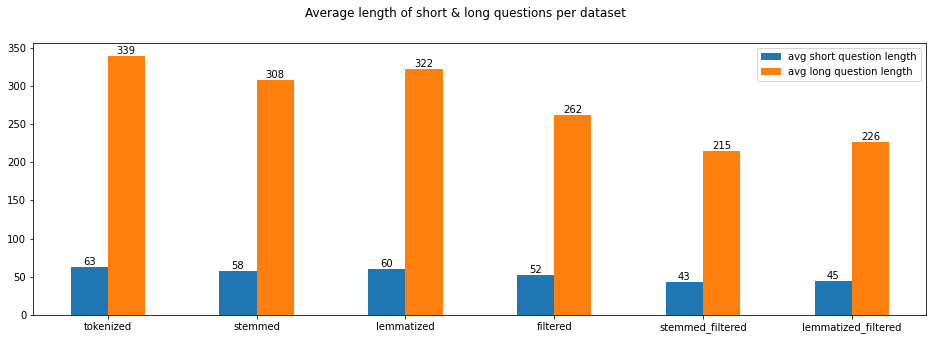

In [49]:
fig, ax = plt.subplots(1, figsize=(16, 5))
fig.suptitle('Average length of short & long questions per dataset')

index = dataset_keys
short_len = []
long_len = []
for key in dataset_keys:
    long_len.append(round(dataframes[key].long_question.str.len().mean()))
    short_len.append(round(dataframes[key].short_question.str.len().mean()))

df = pd.DataFrame({'avg short question length': short_len, 'avg long question length': long_len}, index=index)        

df.plot(kind='bar', ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

for label in ax.containers:
    ax.bar_label(label)

plt.show()

In [50]:
dataframes['filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,Nagy terület őrzésére kutyát javasolnátok Bőve...,Nagy terület őrzésére kutyát javasolnátok Bőve...,A komondor/kuvasz páros kimondottan ezekre a f...,Állatok,Kutyák,train
1,Az álllatorvosunkat alig elérni Ez szerintetek...,Az álllatorvosunkat alig elérni Ez szerintetek...,Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések,val
2,Huskyval szoktatni cicákat,Huskyval szoktatni cicákat A cica először kuty...,"Persze, hogy össze lehet.A kutyának az első pi...",Állatok,Kutyák,train
3,Vadászok Vennék vizslát hobbi célra elvinném v...,Vadászok Vennék vizslát hobbi célra elvinném v...,Normál esetben egy jó idegrendszerű kutyát nem...,Állatok,Kutyák,train
4,Elszállásolhatok kutyát panellakásban napra,Elszállásolhatok kutyát panellakásban napra A ...,"Az a házirend rész érvénytelen, amiben ilyent ...",Állatok,Egyéb kérdések,train


In [51]:
dataframes['stemmed'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,nagy terül őrzés mily kuty javasolnátok? bőveb...,nagy terül őrzés mily kuty javasolnátok? bőveb...,A komondor/kuvasz páros kimondottan ezekre a f...,Állatok,Kutyák,train
1,az álllatorvos al leh elérni. ez szerintet nor...,az álllatorvos al leh elérni. ez szerintet nor...,Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések,val
2,husky össz leh szoktatn cicákat?,husky össz leh szoktatn cicákat? a cic lenn el...,"Persze, hogy össze lehet.A kutyának az első pi...",Állatok,Kutyák,train
3,vadászok! venne egy vizsl hobb cél de elvinne ...,vadászok! venne egy vizsl hobb cél de elvinne ...,Normál esetben egy jó idegrendszerű kutyát nem...,Állatok,Kutyák,train
4,elszállásolhat kuty panellakás néhány napra?,elszállásolhat kuty panellakás néhány napra? a...,"Az a házirend rész érvénytelen, amiben ilyent ...",Állatok,Egyéb kérdések,train


In [52]:
dataframes['lemmatized'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,nagy terület őrzés milyen kutya javasolnát ? b...,nagy terület őrzés milyen kutya javasolnát ? b...,A komondor/kuvasz páros kimondottan ezekre a f...,Állatok,Kutyák,train
1,az álllatorvos alig lehet elér . ez szerintet ...,az álllatorvos alig lehet elér . ez szerintet ...,Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések,val
2,husky össze lehet szoktat cica ?,husky össze lehet szoktat cica ? a cica lenne ...,"Persze, hogy össze lehet.A kutyának az első pi...",Állatok,Kutyák,train
3,vadászok ! vesz egy vizslát hobbi cél de elvis...,vadászok ! vesz egy vizslát hobbi cél de elvis...,Normál esetben egy jó idegrendszerű kutyát nem...,Állatok,Kutyák,train
4,elszállásolhatok kutya panellakás néhány nap ?,elszállásolhatok kutya panellakás néhány nap ?...,"Az a házirend rész érvénytelen, amiben ilyent ...",Állatok,Egyéb kérdések,train


In [53]:
dataframes['filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,Nagy terület őrzésére kutyát javasolnátok Bőve...,Nagy terület őrzésére kutyát javasolnátok Bőve...,A komondor/kuvasz páros kimondottan ezekre a f...,Állatok,Kutyák,train
1,Az álllatorvosunkat alig elérni Ez szerintetek...,Az álllatorvosunkat alig elérni Ez szerintetek...,Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések,val
2,Huskyval szoktatni cicákat,Huskyval szoktatni cicákat A cica először kuty...,"Persze, hogy össze lehet.A kutyának az első pi...",Állatok,Kutyák,train
3,Vadászok Vennék vizslát hobbi célra elvinném v...,Vadászok Vennék vizslát hobbi célra elvinném v...,Normál esetben egy jó idegrendszerű kutyát nem...,Állatok,Kutyák,train
4,Elszállásolhatok kutyát panellakásban napra,Elszállásolhatok kutyát panellakásban napra A ...,"Az a házirend rész érvénytelen, amiben ilyent ...",Állatok,Egyéb kérdések,train


In [54]:
dataframes['stemmed_filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,nagy terül őrzés kuty javasolnát bőveb len,nagy terül őrzés kuty javasolnát bőveb len rég...,A komondor/kuvasz páros kimondottan ezekre a f...,Állatok,Kutyák,train
1,az álllatorvos al elérn ez szerintet normális,az álllatorvos al elérn ez szerintet normális ...,Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések,val
2,husky szoktatn cica,husky szoktatn cica a cic először kutyus össz ...,"Persze, hogy össze lehet.A kutyának az első pi...",Állatok,Kutyák,train
3,vadász venne vizsl hobb cél elvinne vadászat i...,vadász venne vizsl hobb cél elvinne vadászat i...,Normál esetben egy jó idegrendszerű kutyát nem...,Állatok,Kutyák,train
4,elszállásolhat kuty panellakás nap,elszállásolhat kuty panellakás nap a testvérem...,"Az a házirend rész érvénytelen, amiben ilyent ...",Állatok,Egyéb kérdések,train


In [55]:
dataframes['lemmatized_filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,nagy terület őrzés kutya javasolnát bőveb lent,nagy terület őrzés kutya javasolnát bőveb lent...,A komondor/kuvasz páros kimondottan ezekre a f...,Állatok,Kutyák,train
1,az álllatorvos alig elér ez szerintet normális,az álllatorvos alig elér ez szerintet normális...,Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések,val
2,husky szoktat cica,husky szoktat cica a cica először kutyus össze...,"Persze, hogy össze lehet.A kutyának az első pi...",Állatok,Kutyák,train
3,vadászok vennék vizslát hobbi cél elvisz vadás...,vadászok vennék vizslát hobbi cél elvisz vadás...,Normál esetben egy jó idegrendszerű kutyát nem...,Állatok,Kutyák,train
4,elszállásolhatok kutya panellakás nap,elszállásolhatok kutya panellakás nap a testvé...,"Az a házirend rész érvénytelen, amiben ilyent ...",Állatok,Egyéb kérdések,train


In [56]:
dataframes['stemmed_filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,nagy terül őrzés kuty javasolnát bőveb len,nagy terül őrzés kuty javasolnát bőveb len rég...,A komondor/kuvasz páros kimondottan ezekre a f...,Állatok,Kutyák,train
1,az álllatorvos al elérn ez szerintet normális,az álllatorvos al elérn ez szerintet normális ...,Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések,val
2,husky szoktatn cica,husky szoktatn cica a cic először kutyus össz ...,"Persze, hogy össze lehet.A kutyának az első pi...",Állatok,Kutyák,train
3,vadász venne vizsl hobb cél elvinne vadászat i...,vadász venne vizsl hobb cél elvinne vadászat i...,Normál esetben egy jó idegrendszerű kutyát nem...,Állatok,Kutyák,train
4,elszállásolhat kuty panellakás nap,elszállásolhat kuty panellakás nap a testvérem...,"Az a házirend rész érvénytelen, amiben ilyent ...",Állatok,Egyéb kérdések,train


In [57]:
for dataframe_key in dataframes:
    filename = f"{args.output_processed_csv_prefix}{dataframe_key}.csv"
    print(f"Creating {filename}")
    dataframes[dataframe_key].to_csv(filename, index=False, encoding='utf-8', errors='ignore')

Creating .data/faq_with_splits_tokenized.csv
Creating .data/faq_with_splits_stemmed.csv
Creating .data/faq_with_splits_lemmatized.csv
Creating .data/faq_with_splits_filtered.csv
Creating .data/faq_with_splits_stemmed_filtered.csv
Creating .data/faq_with_splits_lemmatized_filtered.csv
